In [1]:
import numpy as np
import pandas as pd

import scipy.stats as st

import scanpy

import altair as alt
from altair import pipe, limit_rows, to_values

# increase row limit for altair
t = lambda data: pipe(data, limit_rows(max_rows=1000000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

# render to png directly to save memory
alt.renderers.register('png', alt.vegalite.v2.display.png_renderer)
alt.renderers.enable('png')

## The effect of PCR on scRNA-seq

One interesting facet of the Tabula Muris data is the fact that we have data from the same samples using two different technologies: microfluidic droplet-based 3’-end counting using the 10x genomics platform, and FACS-based full length transcript analysis with Smart-Seq2. Both platforms have advantages: droplets allow for rapidly profiling thousands of cells, at the cost of  This provided us with the opportunity to compare the advantages of these technologies on a relatively level playing field. For a detailed discussion of this topic, you can check out the [preprint on bioR$\chi$iv](https://www.biorxiv.org/content/early/2018/03/29/237446).

We start with a simple question: when looking at cells of the same type using both technologies, how often do we see evidence of any particular gene?

In [3]:
# read in FACS data
facs_metadata = pd.read_csv('../../data/TM_facs_metadata.csv', index_col=0, dtype=str)
facs_data = scanpy.anndata.read_h5ad('../../data/TM_facs_mat.h5ad')

# read in droplet data
droplet_metadata = pd.read_csv('../../data/TM_droplet_metadata.csv', index_col=0, dtype=str)
droplet_data = scanpy.anndata.read_h5ad('../../data/TM_droplet_mat.h5ad')

facs_thymus = facs_data[:, facs_metadata['tissue'] == 'Thymus']
droplet_thymus = droplet_data[:, droplet_metadata['tissue'] == 'Thymus']

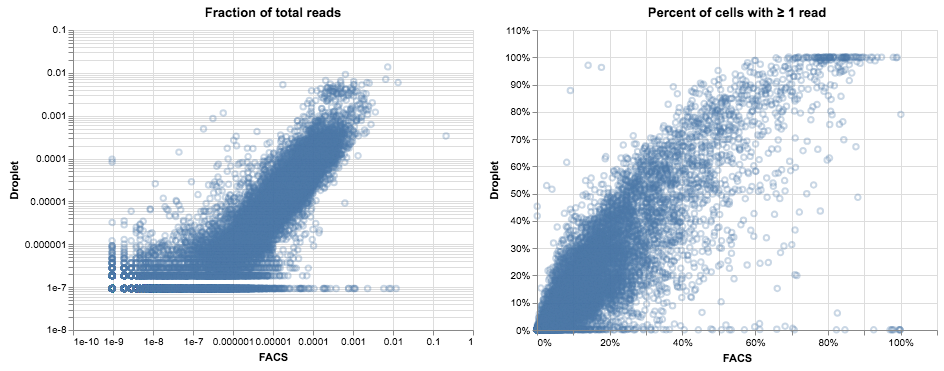

In [4]:
alt.hconcat(
    alt.Chart(
        pd.DataFrame({'Droplet': (droplet_thymus.X.sum(1) + 1) / droplet_thymus.X.sum(), 
                      'FACS': (facs_thymus.X.sum(1) + 1) / facs_thymus.X.sum()}),
        title='Fraction of total reads'
    ).mark_point(opacity=0.3).encode(
        x=alt.X('FACS', type='quantitative', scale=alt.Scale(type='log')), 
        y=alt.Y('Droplet', type='quantitative', scale=alt.Scale(type='log'))
    ),
    alt.Chart(
        pd.DataFrame({'Droplet': (1 + (droplet_thymus.X > 0).sum(1)) / droplet_thymus.X.shape[1], 
                      'FACS': (1 + (facs_thymus.X > 0).sum(1)) / facs_thymus.X.shape[1]}),
        title='Percent of cells with ≥ 1 read'
    ).mark_point(opacity=0.3).encode(
        x=alt.X('FACS', type='quantitative', axis=alt.Axis(format='%')), 
        y=alt.Y('Droplet', type='quantitative', axis=alt.Axis(format='%'))
    )
)

It's tempting to stare at these plots and start to draw conclusions about the relative merits of droplet- and FACS-based methods. Indeed, in the [initial draft](https://www.biorxiv.org/content/early/2017/12/20/237446) we devoted some time to these types of plots. But differences in methodology mean that the data are not exactly comparable. To illustrate that point, we'll change the axes for these plots, and for each method we'll plot the per-gene fraction of total reads versus the percent of cells with ≥1 read.

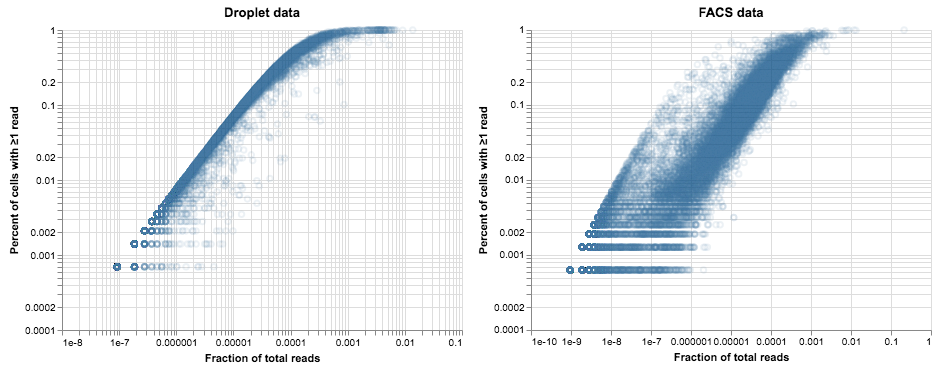

In [14]:

# reusuable plotting function
def plot_expression_v_percent(cell_gene_reads:np.ndarray, title:str):
    cell_gene_nonzero = (cell_gene_reads.sum(0) > 0)
    x = cell_gene_reads[:, cell_gene_nonzero].sum(0) / cell_gene_reads.sum()
    y = (cell_gene_reads[:, cell_gene_nonzero] > 0).sum(0) / cell_gene_reads.shape[0]

    return alt.Chart(pd.DataFrame({'x': x, 'y': y}), title=title).mark_point(opacity=0.1).encode(
        alt.X('x', type='quantitative', scale=alt.Scale(type='log'),
              axis=alt.Axis(title='Fraction of total reads')),
        alt.Y('y', type='quantitative', scale=alt.Scale(type='log'), 
              axis=alt.Axis(title='Percent of cells with ≥1 read'))
    )

plot_expression_v_percent(droplet_thymus.X.T, 'Droplet data') | plot_expression_v_percent(facs_thymus.X.T, title='FACS data')

The difference between these plots is pretty striking. On the droplet side, the relationship between expression and dropout is quite strong: genes that are highly expressed are more likely to be observed in every cell, while low-expression genes are seen less often. This relationship is what we would expect from a Poisson distribution, with the addition of noise due to variation in library depth and expression variation. This data can be modeled as a [negative binomial](http://www.nxn.se/valent/2018/1/30/count-depth-variation-makes-poisson-scrna-seq-data-negative-binomial). Deviations from that model are a sign of heterogeneity in gene expression, and this observation can be used to [select variable genes for analysis](https://www.biorxiv.org/content/biorxiv/early/2017/05/25/065094.full.pdf).

The second plot is more confusing. The same trend is apparent but the points are much more spread out and cloudier compared to the data from the droplets. We see a faint echo of the droplet curve on the left side of the plot, but most of the points are further to the right. If we assumed a negative binomial for these data we would identify a huge number of genes as variable, but we know this population of cells is relatively homogenous (probably as homogenous as the cells in the droplet data).

There must be an additional source of noise, and the obvious suspect is the [PCR](https://en.wikipedia.org/wiki/Polymerase_chain_reaction) amplification during library preparation. The droplet data has unique molecular identifiers (UMIs) that allow us to remove this noise, while the FACS data does not, and the result is what we see. One way to test this idea is to see if our model of how the data were generated can reproduce these results.

[hemberg](https://www.biorxiv.org/content/biorxiv/early/2017/05/25/065094.full.pdf)
[oudenaarden](https://www-nature-com.ucsf.idm.oclc.org/articles/nmeth.2930)
[linnarsson](https://www-nature-com.ucsf.idm.oclc.org/articles/nmeth.2772)
[pcr math](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4666380/)

## What are we measuring? scRNA-seq as a sampling process

We're going to build a [generative model](https://en.wikipedia.org/wiki/Generative_model) of our data, in the hope that we can then understand what's going on in the real data. We'll criminally over-simplify the amount of labwork involved by summarizing single-cell RNA-seq into the following steps:

[figure]?

 1. Cells are **isolated** into wells or droplets
 2. They are lysed, individual mRNA molecules are biochemically **captured** and reverse-transcribed to cDNA
     - in the droplet method, this is where UMIs are introduced
 3. The cDNA is **PCR amplified, fragmented, and amplified again** as part of library preparation
 4. The amplified library is **sequenced**, demultiplexed, aligned, etc.
 
We can think of each of the bolded portions as a sampling step. In step 1, the cells are sampled from a population that contains an unknown amount of diversity, and our collection methods may have different biases at this step. In step 2, individual mRNA molecules are captured with some efficiency that is dependent on the biochemical method and potentially the cell state or even the gene sequence itself. Step 3 can be broken down into many *different* sampling steps, one for each round of PCR, as individual molecules are amplified at different rates of efficiency.

All of these sampling steps are important to think about for experimental design and interpretation. Here we are going to keep steps 1, 2, and 4 constant, by assuming a homogenous cell population, random capture and random sequencing: we will only examine the effect of step 3. Specifically: how does a potentially-biased PCR process affect the final gene count? We'll start by simulating some data.

 1. We have 20,000 genes and 2,000 cells
 2. Genes are expressed according to a log-gamma distribution
     - Formally: $g_i \sim e^{\Gamma(k=2,\ \theta=1)}$ where $k, \theta$ were chosen by eye to mimic realistic data
     - There isn't a strong basis for this distribution except that log-normal looked to be skewed a bit high
 3. Every cell has the same expression state
 4. We'll sample 1,200 UMIs from every cell using a multinomial distribution
     - Technically the [multivariate hypergeometric](https://en.wikipedia.org/wiki/Hypergeometric_distribution#Multivariate_hypergeometric_distribution) is the right distribution here, but it is difficult to implement efficiently and the multinomial has almost identical behavior at this scale.


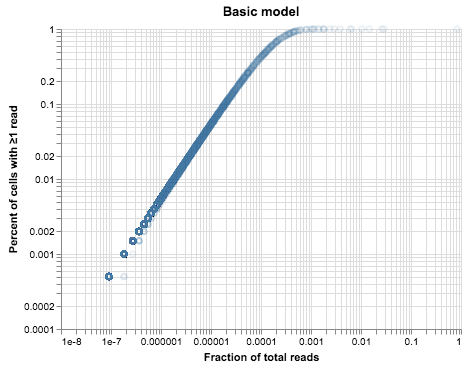

In [6]:
n_genes = 20000
n_cells = 2000
n_umis = 5500 * np.ones(shape=n_cells)

# log-gamma distribution of gene expression 
gene_levels = np.exp(np.random.gamma(4, 1, size=n_genes))

# every cell has the same expression distribution
cell_gene_levels = gene_levels[None,:] * np.ones((n_cells, 1))

# per-cell proportions for each gene, for sampling
gene_p = cell_gene_levels / cell_gene_levels.sum(1)[:, None]

# gene capture: for each cell, select n_reads out of the gene pool as a multinomial process
cell_gene_umis = np.vstack([np.random.multinomial(n_umis[i], gene_p[i,:])
                            for i in range(n_cells)])

plot_expression_v_percent(cell_gene_umis, 'Basic model')


This looks promising! When we consider a specific gene, our sampling process is a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) with $n$ equal to the number of reads and $p$ equal to the relative abundance of that gene in the cell. When $n$ is large and $p$ is small, a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a good approximation for this process, which is why most people refer to scRNA gene counts (assuming no variation between cells) as being [Poisson-distributed](http://www.nxn.se/valent/2018/1/30/count-depth-variation-makes-poisson-scrna-seq-data-negative-binomial). Seeing a particular gene $g$ in a cell is based on the number of reads and the gene's relative expression, and the probability of seeing $k$ reads is given by:

$$ P_g(k\textrm{ reads}) = \frac{\lambda^k e^{-\lambda}}{k!}\hspace{40pt}\lambda = \frac{[\textrm{expression of }g]}{\textrm{[total expression]}} \times \textrm{[number of reads]} $$

When we are counting the prevalence of missing genes, this simplifies to $ P_g(k=0) = e^{-\lambda}$


The plot looks very similar to our droplet data, but it's much cleaner. There are two reasons for that: one is that we simulated identical cells, and the second is that we simulated identical library sizes. We can vary each of these assumptions in turn and see what happens to our data.

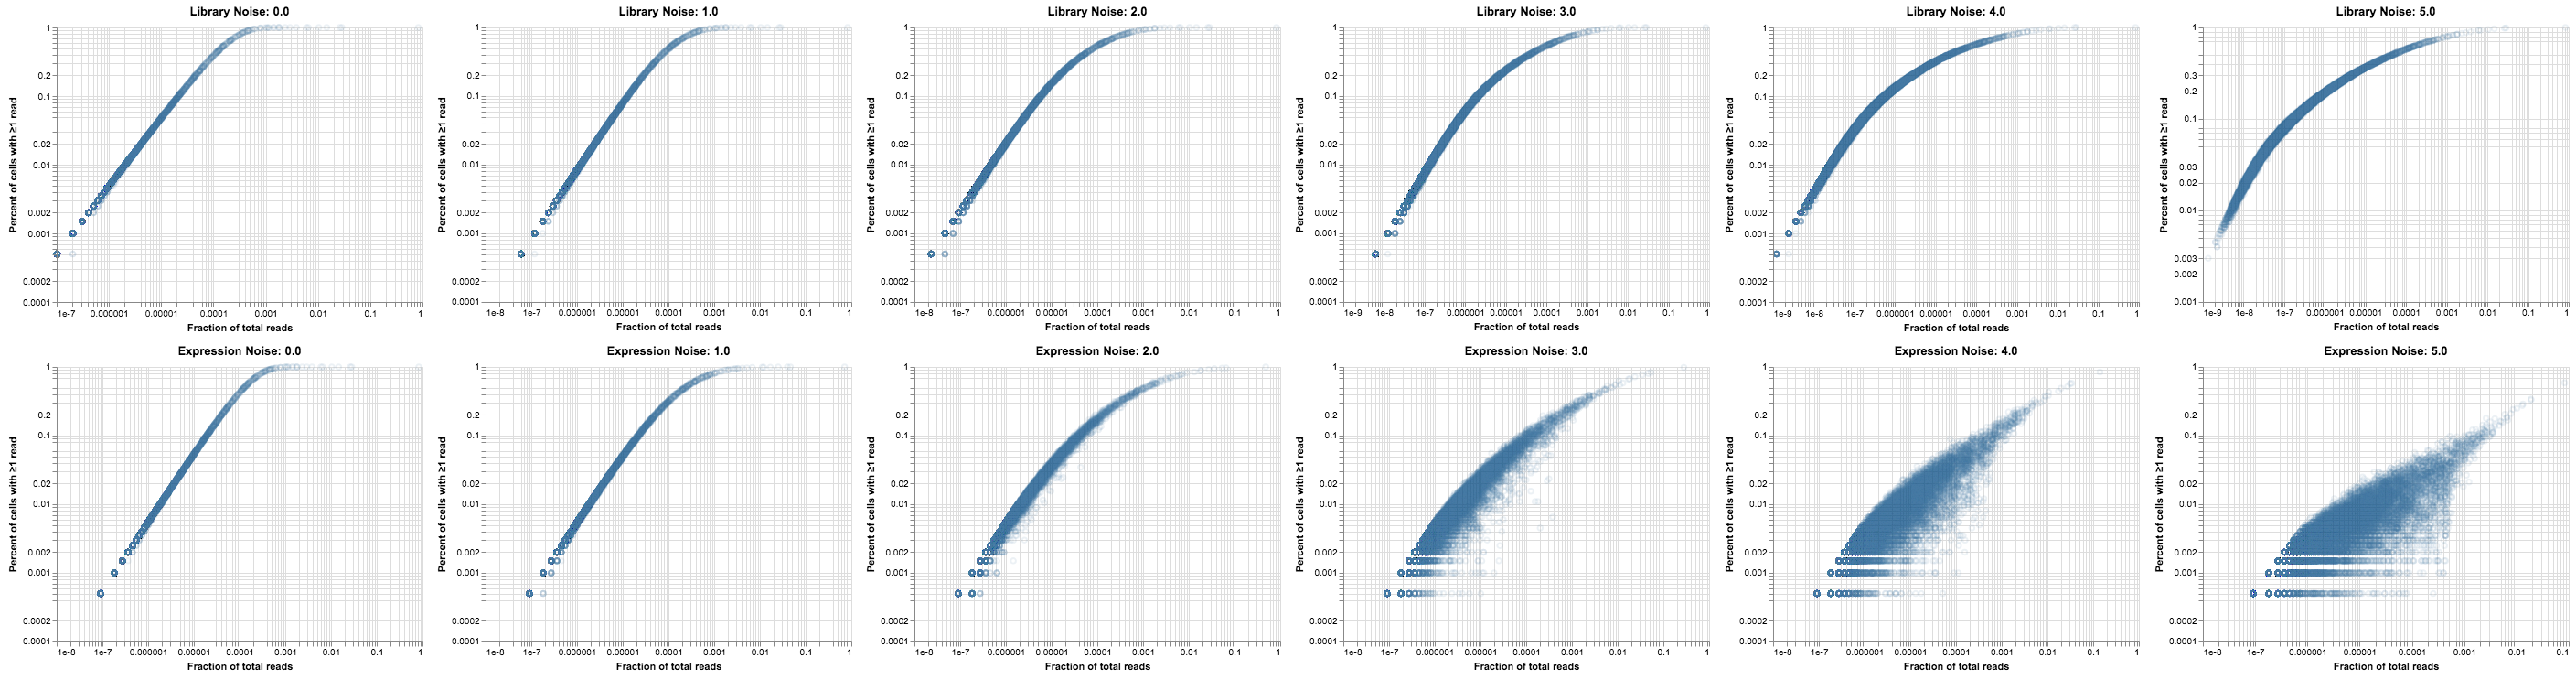

In [9]:
cs = []
# increasing noise levels
for s in np.linspace(0, 5, 6):
    # log-normal noise for the number of reads (with a bounds to represent minimum depth)
    noisy_library = np.exp(st.truncnorm.rvs(-1, 2, loc=8.5, scale=s, size=n_cells)).astype(int)
    
    # gene capture: select a random n_reads out of the gene pool for each cell
    noisy_library_umis = np.vstack([np.random.multinomial(noisy_library[i], gene_p[i,:]) for i in range(n_cells)])
    
    # add log-normal noise to the gene expression of individual cells
    noisy_genes = gene_levels[None,:] * np.exp(np.random.normal(loc=0, scale=s, size=(n_cells, n_genes)))
    noisy_gene_p = noisy_genes / noisy_genes.sum(1)[:, None]
    
    noisy_gene_umis = np.vstack([np.random.multinomial(n_umis[i], noisy_gene_p[i,:]) for i in range(n_cells)])

    cs.append(alt.vconcat(plot_expression_v_percent(noisy_library_umis, f'Library Noise: {s}'),
                          plot_expression_v_percent(noisy_gene_umis, f'Expression Noise: {s}')))

alt.hconcat(*cs)

These plots are useful for gaining an intuition about how noise in our data affects the result. There is a clear difference between these two effects: noise in the size of the library makes the Poisson-derived curve slightly "fuzzier", but it also raises the bottom end of the distribution because the cells have high coverage are able to recover rare genes. Noise in the gene expression lowers the top line and spreads out the distribution, because genes are less evenly distributed and so they are found in fewer cells than would be expected based on expression. In reality we tend to see a combination of these two effects. For this post we'll just eyeball some parameters that look like the droplet data.

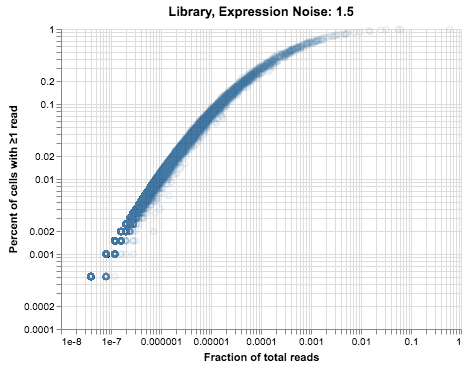

In [10]:
noisy_library = np.exp(st.truncnorm.rvs(-1, 2, loc=8.5, scale=1.5, size=n_cells)).astype(int)

# add log-normal noise to the gene expression of individual cells
noisy_genes = gene_levels[None,:] * np.exp(np.random.normal(loc=0, scale=1.5, size=(n_cells, n_genes)))
# noisy_genes = np.random.gamma(shape=gene_levels/10.0, scale=10.0, size=(n_cells, n_genes))
noisy_gene_p = noisy_genes / noisy_genes.sum(1)[:, None]

noisy_umis = np.vstack([np.random.multinomial(noisy_library[i], noisy_gene_p[i,:]) for i in range(n_cells)])

plot_expression_v_percent(noisy_umis, f'Library, Expression Noise: 1.5')

This plot looks okay. It doesn't look exactly like the thymus data, but our model is still pretty simple in comparison to a real tissue. In particular, we are explicitly simulating a single population, while the real data contains at least three cell types and possibly more that we can't identify.

### Simulating PCR

Our hypothesis is that PCR amplification bias can explain the different between the droplet and FACS plots we saw earlier. PCR amplifies the observed level of each gene, throwing off our estimation of the dropout rate. Furthermore, each gene goes through PCR with a different level of efficiency, which adds noise to the measured gene counts. We can use a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to generate different levels of PCR efficiency on a per-gene basis. Then we represent the PCR amplication as a series of probabilistic doublings, with each gene increasing in abundance according to the number of existing copies and its PCR efficiency rate. If $PCR_{i}(\ j\ )$ is the number of reads for gene $i$ after PCR round $j$, and gene $i$ has a PCR efficency $b_i \sim \beta$, then
 
$$ PCR_{i}(\ j+1\ ) = PCR_{i}(\ j\ ) + \mathrm{Binom}(PCR_{i}(\ j\ ), b_i)$$

That is: in each round of PCR, the each of the existing reads is copied with a probability that is specific to that gene.

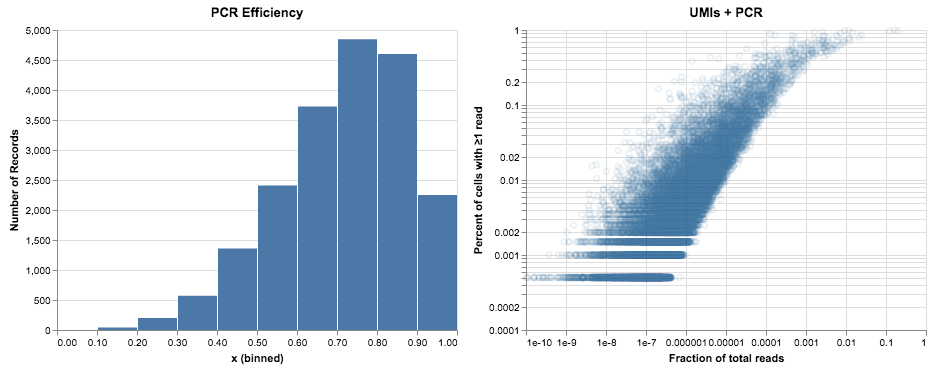

In [12]:
# PCR noise model: every fragment has an affinity for PCR, and every round we do a ~binomial doubling
def pcr_noise(read_counts:np.ndarray, pcr_betas:np.ndarray, n:int):
    read_counts = read_counts.copy()
    # for each round of pcr, each gene increases according to its affinity factor
    for i in range(n):
        read_counts += np.random.binomial(read_counts, pcr_betas[None, :], size=read_counts.shape)

    return read_counts

def plot_pcr_betas(pcr_betas:np.ndarray):
    return alt.Chart(
        pd.DataFrame({'x': pcr_betas}), title='PCR Efficiency'
    ).mark_bar().encode(
        alt.X("x:Q", bin=True), y='count(*):Q',
    )

# gene pcr: each read has a particular affinity for PCR
pcr_betas = np.random.beta(5, 2, size=n_genes)

# thirteen rounds of PCR, as described in the methods
noisy_reads = pcr_noise(noisy_umis, pcr_betas, n=13)

plot_pcr_betas(pcr_betas) | plot_expression_v_percent(noisy_reads, 'UMIs + PCR')

This looks reasonably close to the FACS plot above&mdash;the range in PCR efficiency spreads out the data across a few orders of magnitude. As we go through 13 rounds of PCR the high efficiency genes shift to the right while the lower ones lag behind. The right edge of the curve is fairly sharp, as nothing can replicate more efficiently than once per round.

There is one piece missing from this plot, however, which is the "shadow" of the UMI curve that we could see on the left side. Our intuition from the model so far is that these points are not being amplified very much at all. One way to get more low-efficiency genes would be to use a wider beta distribution (with more density near zero), but it actually looks like there is a small subpopulation with very low efficiency that is separate from the rest. We can model this with a mixture of two beta distributions, although it's unclear why that should be the case. Those of you with more experience troubleshooting PCR can tell us if this seems like a reasonable distribution of efficiency across random DNA sequences.

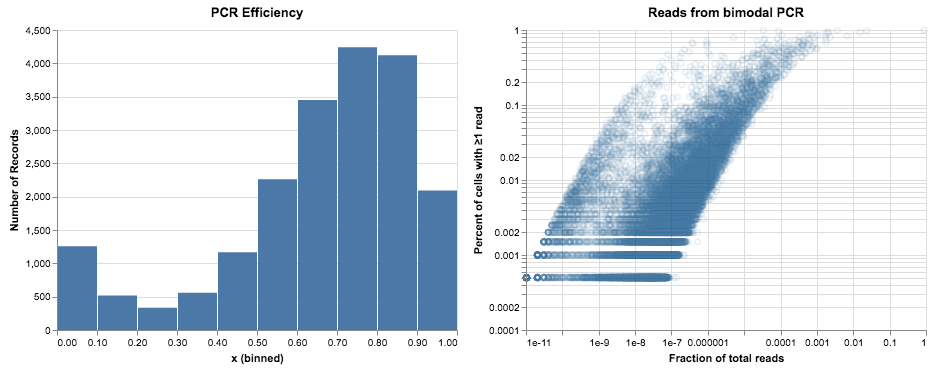

In [16]:
# a bimodel distribution for pcr efficiency: most fragments around 0.7-0.8 but with spike near 0.
pcr_betas = np.vstack((np.random.beta(1, 10, size=n_genes),
                       np.random.beta(5, 2, size=n_genes)))[
    (np.random.random(size=n_genes) > 0.1).astype(int), np.arange(n_genes)
]

noisy_reads = pcr_noise(noisy_umis, pcr_betas, n=13)

plot_pcr_betas(pcr_betas) | plot_expression_v_percent(noisy_reads, 'Reads from bimodal PCR')


This looks pretty good, but it's not quite right. The bimodal distribution gave us a subpopulation of points on the left side of the plot, but it didn't give us the relationship between expression and PCR efficiency that we can see in the FACS data. We could reproduce that relationship in a hacky way, by setting a random subset of low-expression genes to have low PCR efficiency. But that wouldn't be very satisfying&mdash;there's no reason that the PCR reaction should care about the expression level of the genes.

However, there's another factor that we haven't considered yet. When we do scRNA-seq we aren't sequencing entire gene transcripts, we're sequencing _fragments_. The number of different fragments we see from a gene will depend on its expression level, because a highly-expressed gene will be sampled more often and so we are more likely to see multiple different fragments. A gene with low expression could potentially be represented by a single fragment, and if that fragment has poor PCR efficiency, it would remain on the UMI curve, leaving us the "shadow" that we expected. We can try this out by changing our model to work on gene fragments rather than genes. Most of it is the same, but in the beginning we add a step of generating a random number of fragments for each gene (Poisson distributed) and assigning each one its own PCR efficiency. We'll show the results of both the UMI distribution and the PCR-amplified version.

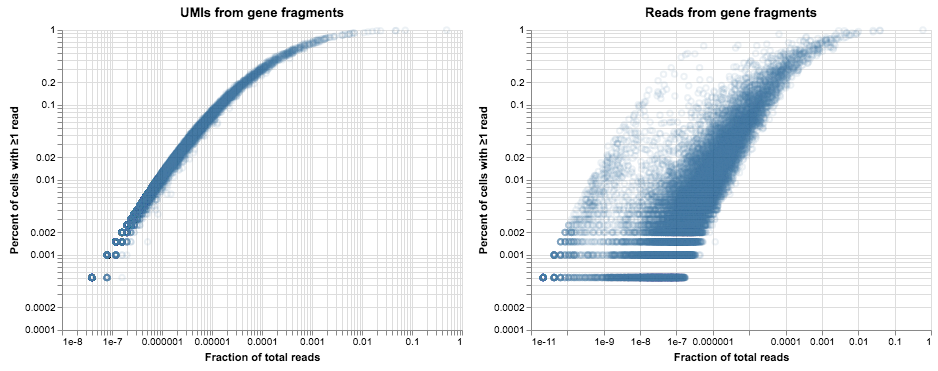

In [17]:
# random number of possible fragments per gene, poisson distributed
fragments_per_gene = 1 + np.random.poisson(1, size=n_genes) # add one to ensure ≥1 fragment per gene
fragment_i = np.repeat(np.arange(n_genes), fragments_per_gene) # index for fragments
n_fragments = fragments_per_gene.sum() # total number of fragments 

# each fragment is at the level of the gene it comes from
noisy_fragments = np.repeat(noisy_genes, fragments_per_gene, axis=1)
noisy_fragment_p = noisy_fragments / noisy_fragments.sum(1)[:, None]

# randomly sample fragments, rather than genes, according the per-cell library size
fragment_umis = np.vstack([np.random.multinomial(noisy_library[i], noisy_fragment_p[i,:]) 
                            for i in range(n_cells)])

# sum up all the fragment reads for a gene to get per-gene UMI counts
gene_umis = np.hstack([fragment_umis[:, fragment_i == i].sum(1)[:, None] for i in range(n_genes)])

# generate a per-fragment PCR efficiency
pcr_betas = np.vstack((np.random.beta(1, 10, size=n_fragments),
                       np.random.beta(5, 2, size=n_fragments)))[
    (np.random.random(size=n_fragments) > 0.1).astype(int), np.arange(n_fragments)
]

# amplify the fragments with PCR
fragment_reads = pcr_noise(fragment_umis, pcr_betas, n=13)

# sum up all the fragment reads to get per-gene read counts
gene_reads = np.hstack([fragment_reads[:, fragment_i == i].sum(1)[:, None] for i in range(n_genes)])

plot_expression_v_percent(gene_umis, 'UMIs from gene fragments') | plot_expression_v_percent(gene_reads, 'Reads from gene fragments')

Now that's more like it! We have most of the characteristics of the plot we generated from real data, with the exception of what is most likely biological noise and possibly the tweaking of some parameters. The addition of gene fragments didn't change how our model behaves on UMI data, but it allowed us to reproduce the "shadow" of the UMI curve for low-expression genes.

### Conclusions

This model isn't perfect, but it is mostly consistent with how we believe the data are actually produced, and it generates simulated data that look like our real data. One open question is whether the distribution of PCR efficiencies is realistic. A bimodal distribution _might_ reflect that some proportion of cDNA sequences form dimers or otherwise impede PCR, but a unimodal distribution is more intuitive. It's possible that we're missing yet another mechanism in this process that would naturally lead to the behavior we're seeing.

While this blog post is mostly about a particularly confusing plot and trying to understand its behavior, it was not a purely theoretical exercise. There are a few ideas that arise from this model of our data.

 1. Looking at these plots and how they are affected by noise has emphasized the importance of UMIs for getting a good estimate of gene expression. By having a strong statistical model for how the data are generated, we can more easily identify genes with heterogeneous expression within a cluster. This level of detail is much more difficult to resolve when read counts are affected by amplification noise.
 2. We spent a fair amount of time trying to recreate the shadow on the left side of the FACS plot, but we haven't discussed the implications of that shadow. According to our model, those are genes that have very low PCR efficiency and may not have been amplified at all during the second PCR step. Nevertheless, we are recovering those reads from the sequencer at a rate consistent with their expression. This suggests that we might be able to optimize our protocols by doing fewer rounds of library amplification. That would allow us to improve our sequencing throughput, either by sequencing more cells at once or by sequencing the same number of cells much more deeply.
 3. When we are confident that we have a homogenous cluster of cells, the plots above show us a natural method of imputing gene expression values when they are missing, even in the face of PCR noise. The proportion of cells with ≥1 read is a good predictor of the number of UMIs in each cell, and this holds true even when the reads themselves are subjected to a biased PCR process. The points in the second plot have shifted to the right but not up or down, so it's possible the effect of amplification can be removed by fitting a curve to the top left of the graph. However, when we are not confident of a homogenous population this becomes much riskier, and it is harder to have that confidence in the face of noisy reads.

# The Tabula Muris project
The Tabula Muris project is built on a large set of single-cell mRNA sequencing data, representing around 100000 cells from 20 organs and tissues from four mice. We are hopeful that this dataset will be broadly useful to the community as a place to validate findings, formulate new biological hypotheses, and benchmark novel methods and tools. To get the party started, we're publishing a series of posts on our blog that highlight different aspects of this dataset and the different research questions that it led us to explore.

### Posts in this series:

 1. [Intro](link) - introduction and overview
 2. [Another post](link) - a post
 3. [Something else](link) - another post
 